In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

# from PIL import Image
# import torchvision.transforms as transforms

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...


In [9]:
# 転写元ディレクトリ
from_img_dir = 'videos/video1_frames_align'
if not os.path.exists(from_img_dir):
    print('no directory')

# 転写先ディレクトリ
to_img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(to_img_dir)):
    print(f'{i}: {file}')

0: check1.png
1: check2.png
2: idPhoto.png
3: megane.png
4: sample01.png
5: sandy.png
6: test02.png
7: women_default.png
8: yotaka_default.png
9: yotaka_smile.png


In [12]:
data = ImageDataset(from_img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False, sort_names=True)
num_frames = len(os.listdir(from_img_dir))
batch_from = np.array(data[0]['img'][None])
for i in range(1, num_frames):
    batch_from = np.append(batch_from, data[i]['img'][None], axis=0)
batch_from = torch.tensor(batch_from)

data2 = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_to = data2[1]['img'][None]

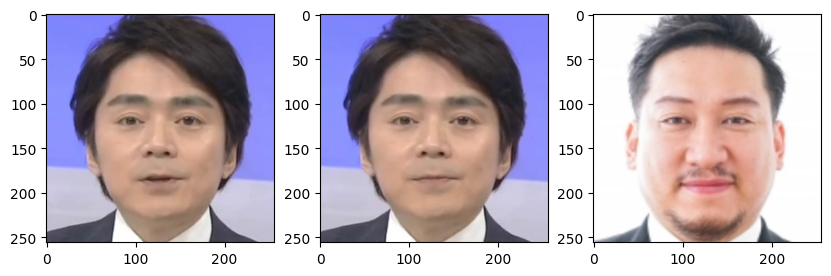

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(batch_from[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_from[1].permute([1, 2, 0]) / 2 + 0.5)
ax[2].imshow(batch_to[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [21]:
cond_to = model.encode(batch_to.to(device))
cond_to_norm = cls_model.normalize(cond_to)
xT = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

cond_from1 = model.encode(batch_from[0][None].to(device))
cond_from1_norm = cls_model.normalize(cond_from1)
conds = []
for i in range(num_frames):
    cond_from2 = model.encode(batch_from[i][None].to(device))
    cond_change = cls_model.normalize(cond_from2) - cond_from1_norm
    cond = cond_to_norm + cond_change
    cond = cls_model.denormalize(cond)
    conds.append(cond)

In [28]:
preds = []
for i in range(num_frames):
    cond = model.encode(batch_from[i][None].to(device))
    xT = model.encode_stochastic(batch_from[i][None].to(device), cond, T=250)
    pred = model.render(xT, cond, T=20)
    preds.append(pred[0])

In [29]:
preds_pil = []
for pred in preds:
    preds_pil.append(torchvision.transforms.functional.to_pil_image(pred))

https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html

In [30]:
preds_pil[0].save(
    'videos/video1_align.gif',
    format='gif',
    save_all=True,
    append_images=preds_pil,
    duration=33,
    loop=0,
)

In [26]:
batch_from_pil = []
for i in batch_from:
    batch_from_pil.append(torchvision.transforms.functional.to_pil_image(i/2+0.5))

In [27]:
batch_from_pil[0].save(
    'videos/video1_original.gif',
    format='gif',
    save_all=True,
    append_images=batch_from_pil,
    duration=33,
    loop=0,
)

## 部位ごと

In [24]:
# 転写元ディレクトリ
from_no_img_dir = 'videos/materials/no_image_frames'
if not os.path.exists(from_no_img_dir):
    print('no directory')
    
from_eye_img_dir = 'videos/materials/eye_image_frames'
if not os.path.exists(from_eye_img_dir):
    print('no directory')
    
from_mouth_img_dir = 'videos/materials/mouth_image_frames'
if not os.path.exists(from_mouth_img_dir):
    print('no directory')

# 転写先ディレクトリ
to_img_dir = 'imgs_align'
for i,file in enumerate(os.listdir(to_img_dir)):
    print(f'{i}: {file}')

0: check1.png
1: check2.png
2: idPhoto.png
3: megane.png
4: sample01.png
5: sandy.png
6: test02.png
7: video1_001.png
8: women_default.png
9: yotaka_default.png
10: yotaka_smile.png


In [25]:
data_no_image = ImageDataset(from_no_img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False, sort_names=True)
data_eye_image = ImageDataset(from_eye_img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False, sort_names=True)
data_mouth_image = ImageDataset(from_mouth_img_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False, sort_names=True)

num_frames = len(os.listdir(from_no_img_dir))
batch_from_no_image = np.array(data_no_image[0]['img'][None])
for i in range(1, num_frames):
    batch_from_no_image = np.append(batch_from_no_image, data_no_image[i]['img'][None], axis=0)
batch_from_no_image = torch.tensor(batch_from_no_image)

batch_from_eye_image = np.array(data_eye_image[0]['img'][None])
for i in range(1, num_frames):
    batch_from_eye_image = np.append(batch_from_eye_image, data_eye_image[i]['img'][None], axis=0)
batch_from_eye_image = torch.tensor(batch_from_eye_image)

batch_from_mouth_image = np.array(data_mouth_image[0]['img'][None])
for i in range(1, num_frames):
    batch_from_mouth_image = np.append(batch_from_mouth_image, data_mouth_image[i]['img'][None], axis=0)
batch_from_mouth_image = torch.tensor(batch_from_mouth_image)

data2 = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_to = data2[7]['img'][None]

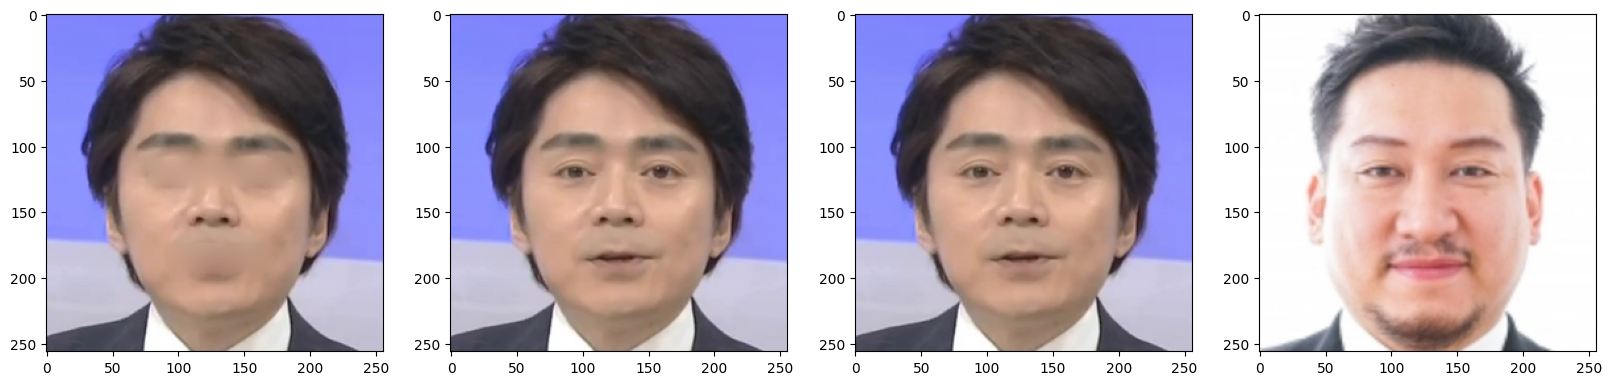

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(batch_from_no_image[0].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_from_eye_image[0].permute([1, 2, 0]) / 2 + 0.5)
ax[2].imshow(batch_from_mouth_image[0].permute([1, 2, 0]) / 2 + 0.5)
ax[3].imshow(batch_to[0].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [26]:
cond_to = model.encode(batch_to.to(device))
cond_to_norm = cls_model.normalize(cond_to)
xT = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

cond_from_no1 = model.encode(batch_from_no_image[0][None].to(device))
cond_from_no1_norm = cls_model.normalize(cond_from_no1)
conds_no = []
cond_from_eye1 = model.encode(batch_from_eye_image[0][None].to(device))
cond_from_eye1_norm = cls_model.normalize(cond_from_eye1)
conds_eye = []
cond_from_mouth1 = model.encode(batch_from_mouth_image[0][None].to(device))
cond_from_mouth1_norm = cls_model.normalize(cond_from_mouth1)
conds_mouth = []
conds_all = []
conds_face = []

for i in range(num_frames):
    cond_from_no2 = model.encode(batch_from_no_image[i][None].to(device))
    cond_change_no = cls_model.normalize(cond_from_no2) - cond_from_no1_norm
    cond_no = cond_to_norm + cond_change_no
    cond_no = cls_model.denormalize(cond_no)
    conds_no.append(cond_no)
    
    cond_from_eye2 = model.encode(batch_from_eye_image[i][None].to(device))
    cond_change_eye = cls_model.normalize(cond_from_eye2) - cond_from_eye1_norm
    cond_eye = cond_to_norm + cond_change_eye
    cond_eye = cls_model.denormalize(cond_eye)
    conds_eye.append(cond_eye)
    
    cond_from_mouth2 = model.encode(batch_from_mouth_image[i][None].to(device))
    cond_change_mouth = cls_model.normalize(cond_from_mouth2) - cond_from_mouth1_norm
    cond_mouth = cond_to_norm + cond_change_mouth
    cond_mouth = cls_model.denormalize(cond_mouth)
    conds_mouth.append(cond_mouth)
    
    cond_all = cond_to_norm + cond_change_no + cond_change_eye + cond_change_mouth
    cond_all = cls_model.denormalize(cond_all)
    conds_all.append(cond_all)
    cond_face = cond_to_norm + cond_change_eye + cond_change_mouth
    cond_face = cls_model.denormalize(cond_face)
    conds_face.append(cond_face)
    
    torch.cuda.empty_cache()

In [27]:
# preds_no = []
# for cond in conds_no:
#     pred = model.render(xT, cond, T=20)
#     preds_no.append(pred[0])
# torch.cuda.empty_cache()

# preds_eye = []
# for cond in conds_eye:
#     pred = model.render(xT, cond, T=20)
#     preds_eye.append(pred[0])
# torch.cuda.empty_cache()

# preds_mouth = []
# for cond in conds_mouth:
#     pred = model.render(xT, cond, T=20)
#     preds_mouth.append(pred[0])
# torch.cuda.empty_cache()

preds_all = []
for cond in conds_all:
    pred = model.render(xT, cond, T=20)
    preds_all.append(pred[0])
torch.cuda.empty_cache()

# preds_face = []
# for cond in conds_face:
#     pred = model.render(xT, cond, T=20)
#     preds_face.append(pred[0])
# torch.cuda.empty_cache()

In [28]:
# preds_no_pil = []
# for pred in preds_no:
#     preds_no_pil.append(torchvision.transforms.functional.to_pil_image(pred))

# preds_eye_pil = []
# for pred in preds_eye:
#     preds_eye_pil.append(torchvision.transforms.functional.to_pil_image(pred))

# preds_mouth_pil = []
# for pred in preds_mouth:
#     preds_mouth_pil.append(torchvision.transforms.functional.to_pil_image(pred))

preds_all_pil = []
for pred in preds_all:
    preds_all_pil.append(torchvision.transforms.functional.to_pil_image(pred))

# preds_face_pil = []
# for pred in preds_face:
#     preds_face_pil.append(torchvision.transforms.functional.to_pil_image(pred))

In [29]:
# preds_no_pil[0].save(
#     'videos/video1_no.gif',
#     format='gif',
#     save_all=True,
#     append_images=preds_no_pil,
#     duration=33,
#     loop=0,
# )

# preds_eye_pil[0].save(
#     'videos/video1_eye.gif',
#     format='gif',
#     save_all=True,
#     append_images=preds_eye_pil,
#     duration=33,
#     loop=0,
# )

# preds_mouth_pil[0].save(
#     'videos/video1_mouth.gif',
#     format='gif',
#     save_all=True,
#     append_images=preds_mouth_pil,
#     duration=33,
#     loop=0,
# )

preds_all_pil[0].save(
    'videos/video1_trans_001_all.gif',
    format='gif',
    save_all=True,
    append_images=preds_all_pil,
    duration=33,
    loop=0,
)

# preds_face_pil[0].save(
#     'videos/video1_face.gif',
#     format='gif',
#     save_all=True,
#     append_images=preds_face_pil,
#     duration=33,
#     loop=0,
# )